In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]

In [ ]:
try:
    if tf.test.gpu_device_name():
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print('GPU active! -', physical_devices)
    else:
        print('GPU not active!')
except Exception as e:
    print('An error occurred while checking the GPU:', e)

GPU not active!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A search has been initiated within the folder named 'alzhiemers'.
There are 0 images in the Very_Mild_Demented folder.
There are 3210 images in the Non_Demented folder.
There are 0 images in the Moderate_Demented folder.
There are 0 images in the Mild_Demented folder.
There are 2250 images in the Very_Mild_Demented folder.
There are 64 images in the Moderate_Demented folder.
There are 896 images in the Mild_Demented folder.
The search has been completed.


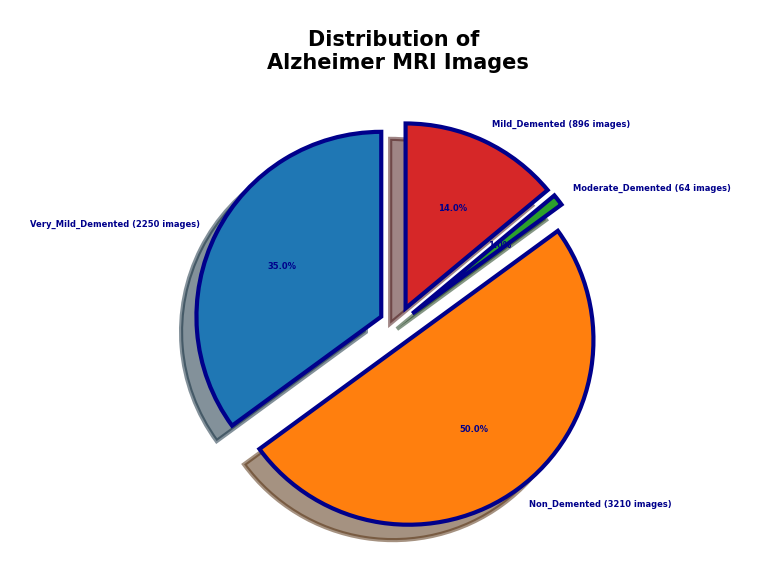

In [ ]:
import os
import matplotlib.pyplot as plt

class_dist = {}

def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"A search has been initiated within the folder named '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = sum(1 for filename in os.listdir(dir_path) if os.path.splitext(filename)[1].lower() in image_extensions)

            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")

    print('\033[92m'+"The search has been completed."+'\033[0m')

    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)
    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]

    # Set figure size (width=6, height=6 decreases the size)
    plt.figure(figsize=(2, 2))  # Adjust these values as needed

    plt.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 2, "fontweight": "bold", "color": "darkblue"},
            wedgeprops={'edgecolor': 'darkblue'})

    plt.title("Distribution of \nAlzheimer MRI Images", fontsize=5, fontweight="bold")
    plt.show()

# Example usage
PATH = '/content/drive/MyDrive/alzhiemers'
image_counter(PATH)


In [ ]:
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names

Found 6420 files belonging to 4 classes.


IndexError: list index out of range

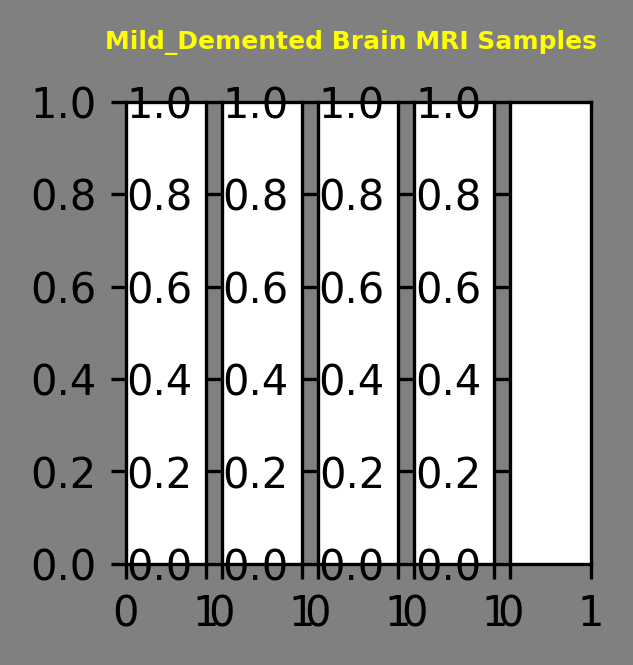

In [ ]:
def sample_bringer(path, target, num_samples=5):

    class_path = os.path.join(path, target)

    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, facecolor="gray",figsize=(2, 2))
    fig.suptitle(f'{target} Brain MRI Samples', color="yellow",fontsize=6, fontweight='bold', y=1)

    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}', color="aqua")

    plt.tight_layout()

for target in class_names:
    sample_bringer(PATH, target=target)

In [ ]:
def sample_bringer(path, target, num_samples=5):

    class_path = os.path.join(path, target)

    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    # Check if there are enough images in the folder
    num_samples = min(num_samples, len(image_files))
    # If not, adjust num_samples to the number of available images

    fig, ax = plt.subplots(1, num_samples, facecolor="gray")
    fig.suptitle(f'{target} Brain MRI Samples', color="yellow",fontsize=16, fontweight='bold', y=0.75)

    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}', color="aqua")

    plt.tight_layout()

In [ ]:
alz_dict = {index: img for index, img in enumerate(data.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())

    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="gray")
        fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="yellow",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="aqua")
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])

    def train_test_val_split(self, train_size, val_size, test_size):

        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)

        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data

Min and max pixel values in the batch -> 0.0 & 1.0


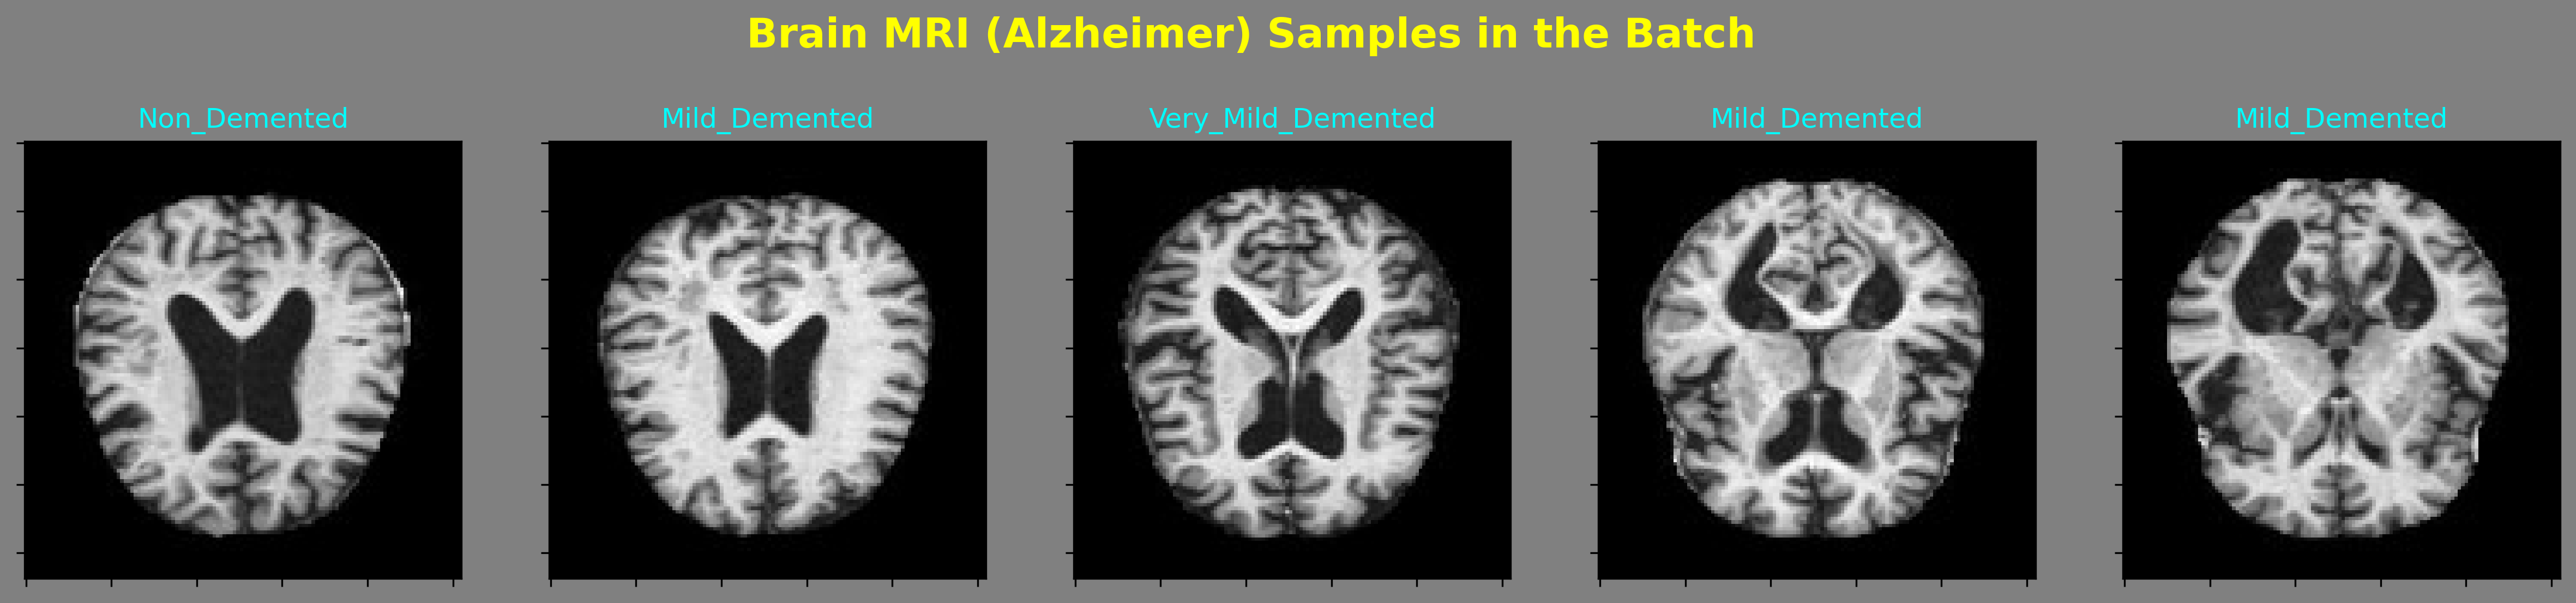

In [ ]:
process = Process(data)
process.create_new_batch()
process.show_batch_images(number_of_images=5)

In [ ]:
train_data, val_data, test_data= process.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)

In [ ]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, SimpleRNN, TimeDistributed

def build_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add TimeDistributed layer to make the output 3D
    model.add(TimeDistributed(Flatten()))

    # Add Simple RNN layer
    model.add(SimpleRNN(units=64, activation='relu'))

    model.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    model.summary()

    return model

model = build_model()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 14, 1792)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 64)                  │         118,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 177,764 (694.39 KB)

 Trainable params: 177,764 (694.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def checkpoint_callback():

    checkpoint_filepath = '/tmp/checkpoint.keras' # Changed filepath to end with .keras

    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           # The 'frequency' argument has been replaced by 'save_freq'
                           save_freq='epoch',  # or save_freq= 'epoch' to save every epoch
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

In [ ]:
# prompt: epoches

# Define EPOCHS if not already defined
EPOCHS = 25  # You can change this value

# Call the checkpoint_callback function and assign the result to 'callbacks'
callbacks = [checkpoint_callback()]  # Enclose in a list

# Fit the model with the callback
history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data, class_weight=class_weights, callbacks=callbacks)


Epoch 1/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.2605 - loss: 1.3694
Epoch 1: val_accuracy improved from -inf to 0.01562, saving model to /tmp/checkpoint.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.2605 - loss: 1.3698 - val_accuracy: 0.0156 - val_loss: 1.5696
Epoch 2/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.1676 - loss: 1.3342
Epoch 2: val_accuracy improved from 0.01562 to 0.01719, saving model to /tmp/checkpoint.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 124s 768ms/step - accuracy: 0.1679 - loss: 1.3345 - val_accuracy: 0.0172 - val_loss: 1.4133
Epoch 3/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.1222 - loss: 1.3634
Epoch 3: val_accuracy improved from 0.01719 to 0.01875, saving model to /tmp/checkpoint.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 133s 717ms/step - accuracy: 0.1221 - loss: 1.3637 - val_accuracy: 0.0188 - val_loss: 1.4006
Epoch 4/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.1797 - loss: 1.3348
Epoch 4: 

In [ ]:
model.save("your_model_name.h5")


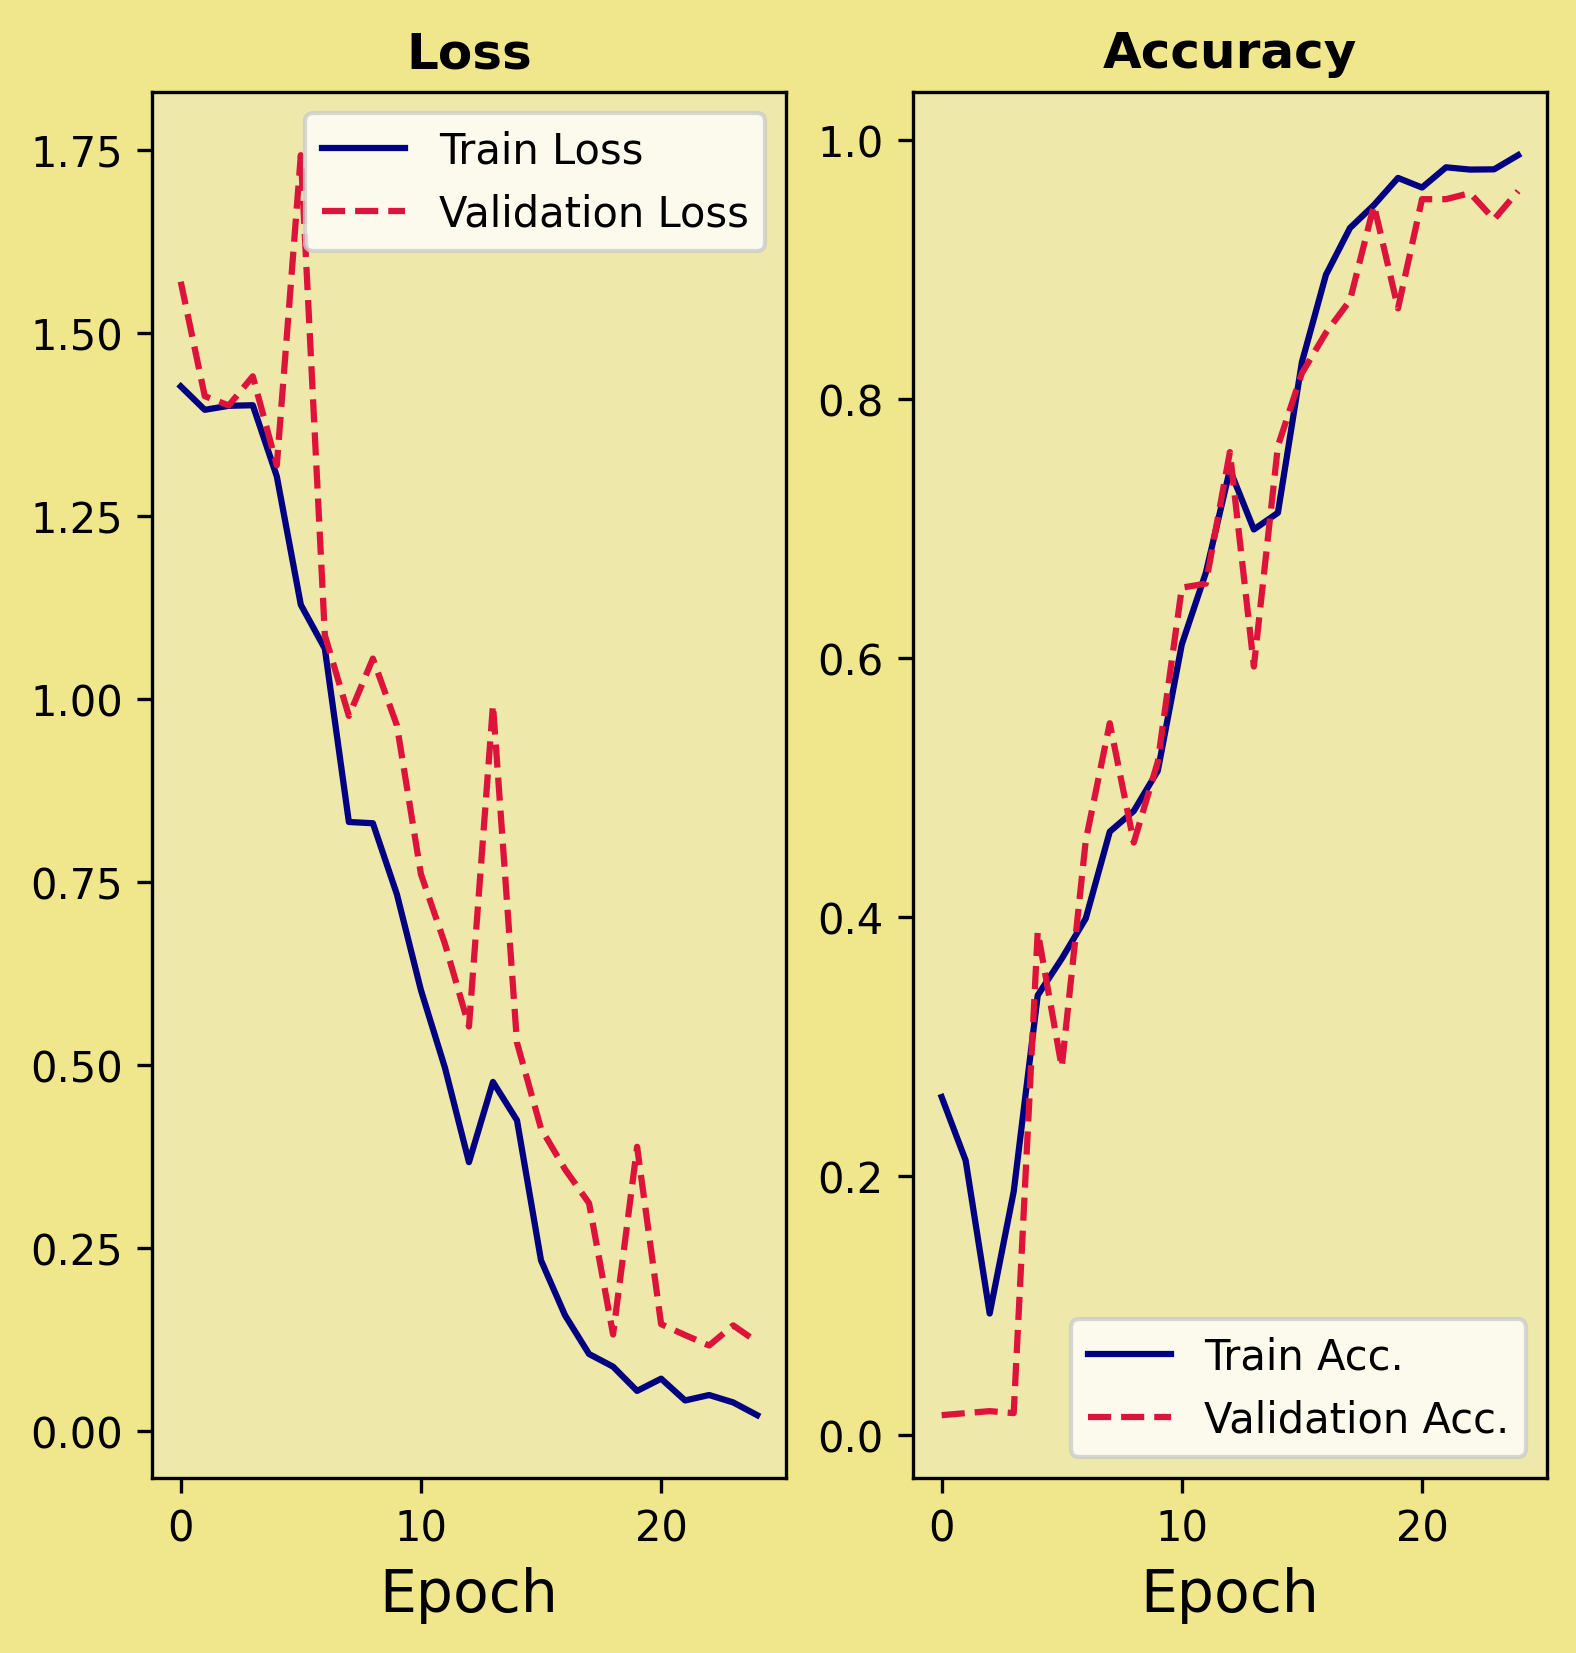

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6,6), facecolor="khaki")
ax[0].set_facecolor('palegoldenrod')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="navy")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="crimson", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('palegoldenrod')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="crimson", linestyle="dashed")
ax[1].legend()

In [ ]:
  model.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step - accuracy: 0.9594 - loss: 0.0994


[0.12467378377914429, 0.956250011920929]

20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.9537 - loss: 0.1125
Test Loss: 0.1159
Test Accuracy: 0.9563
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 207ms/step
                    precision    recall  f1-score   support

     Mild_Demented       0.10      0.11      0.11        80
 Moderate_Demented       0.00      0.00      0.00         4
      Non_Demented       0.46      0.44      0.45       317
Very_Mild_Demented       0.40      0.40      0.40       239

          accuracy                           0.38       640
         macro avg       0.24      0.24      0.24       640
      weighted avg       0.39      0.38      0.39       640



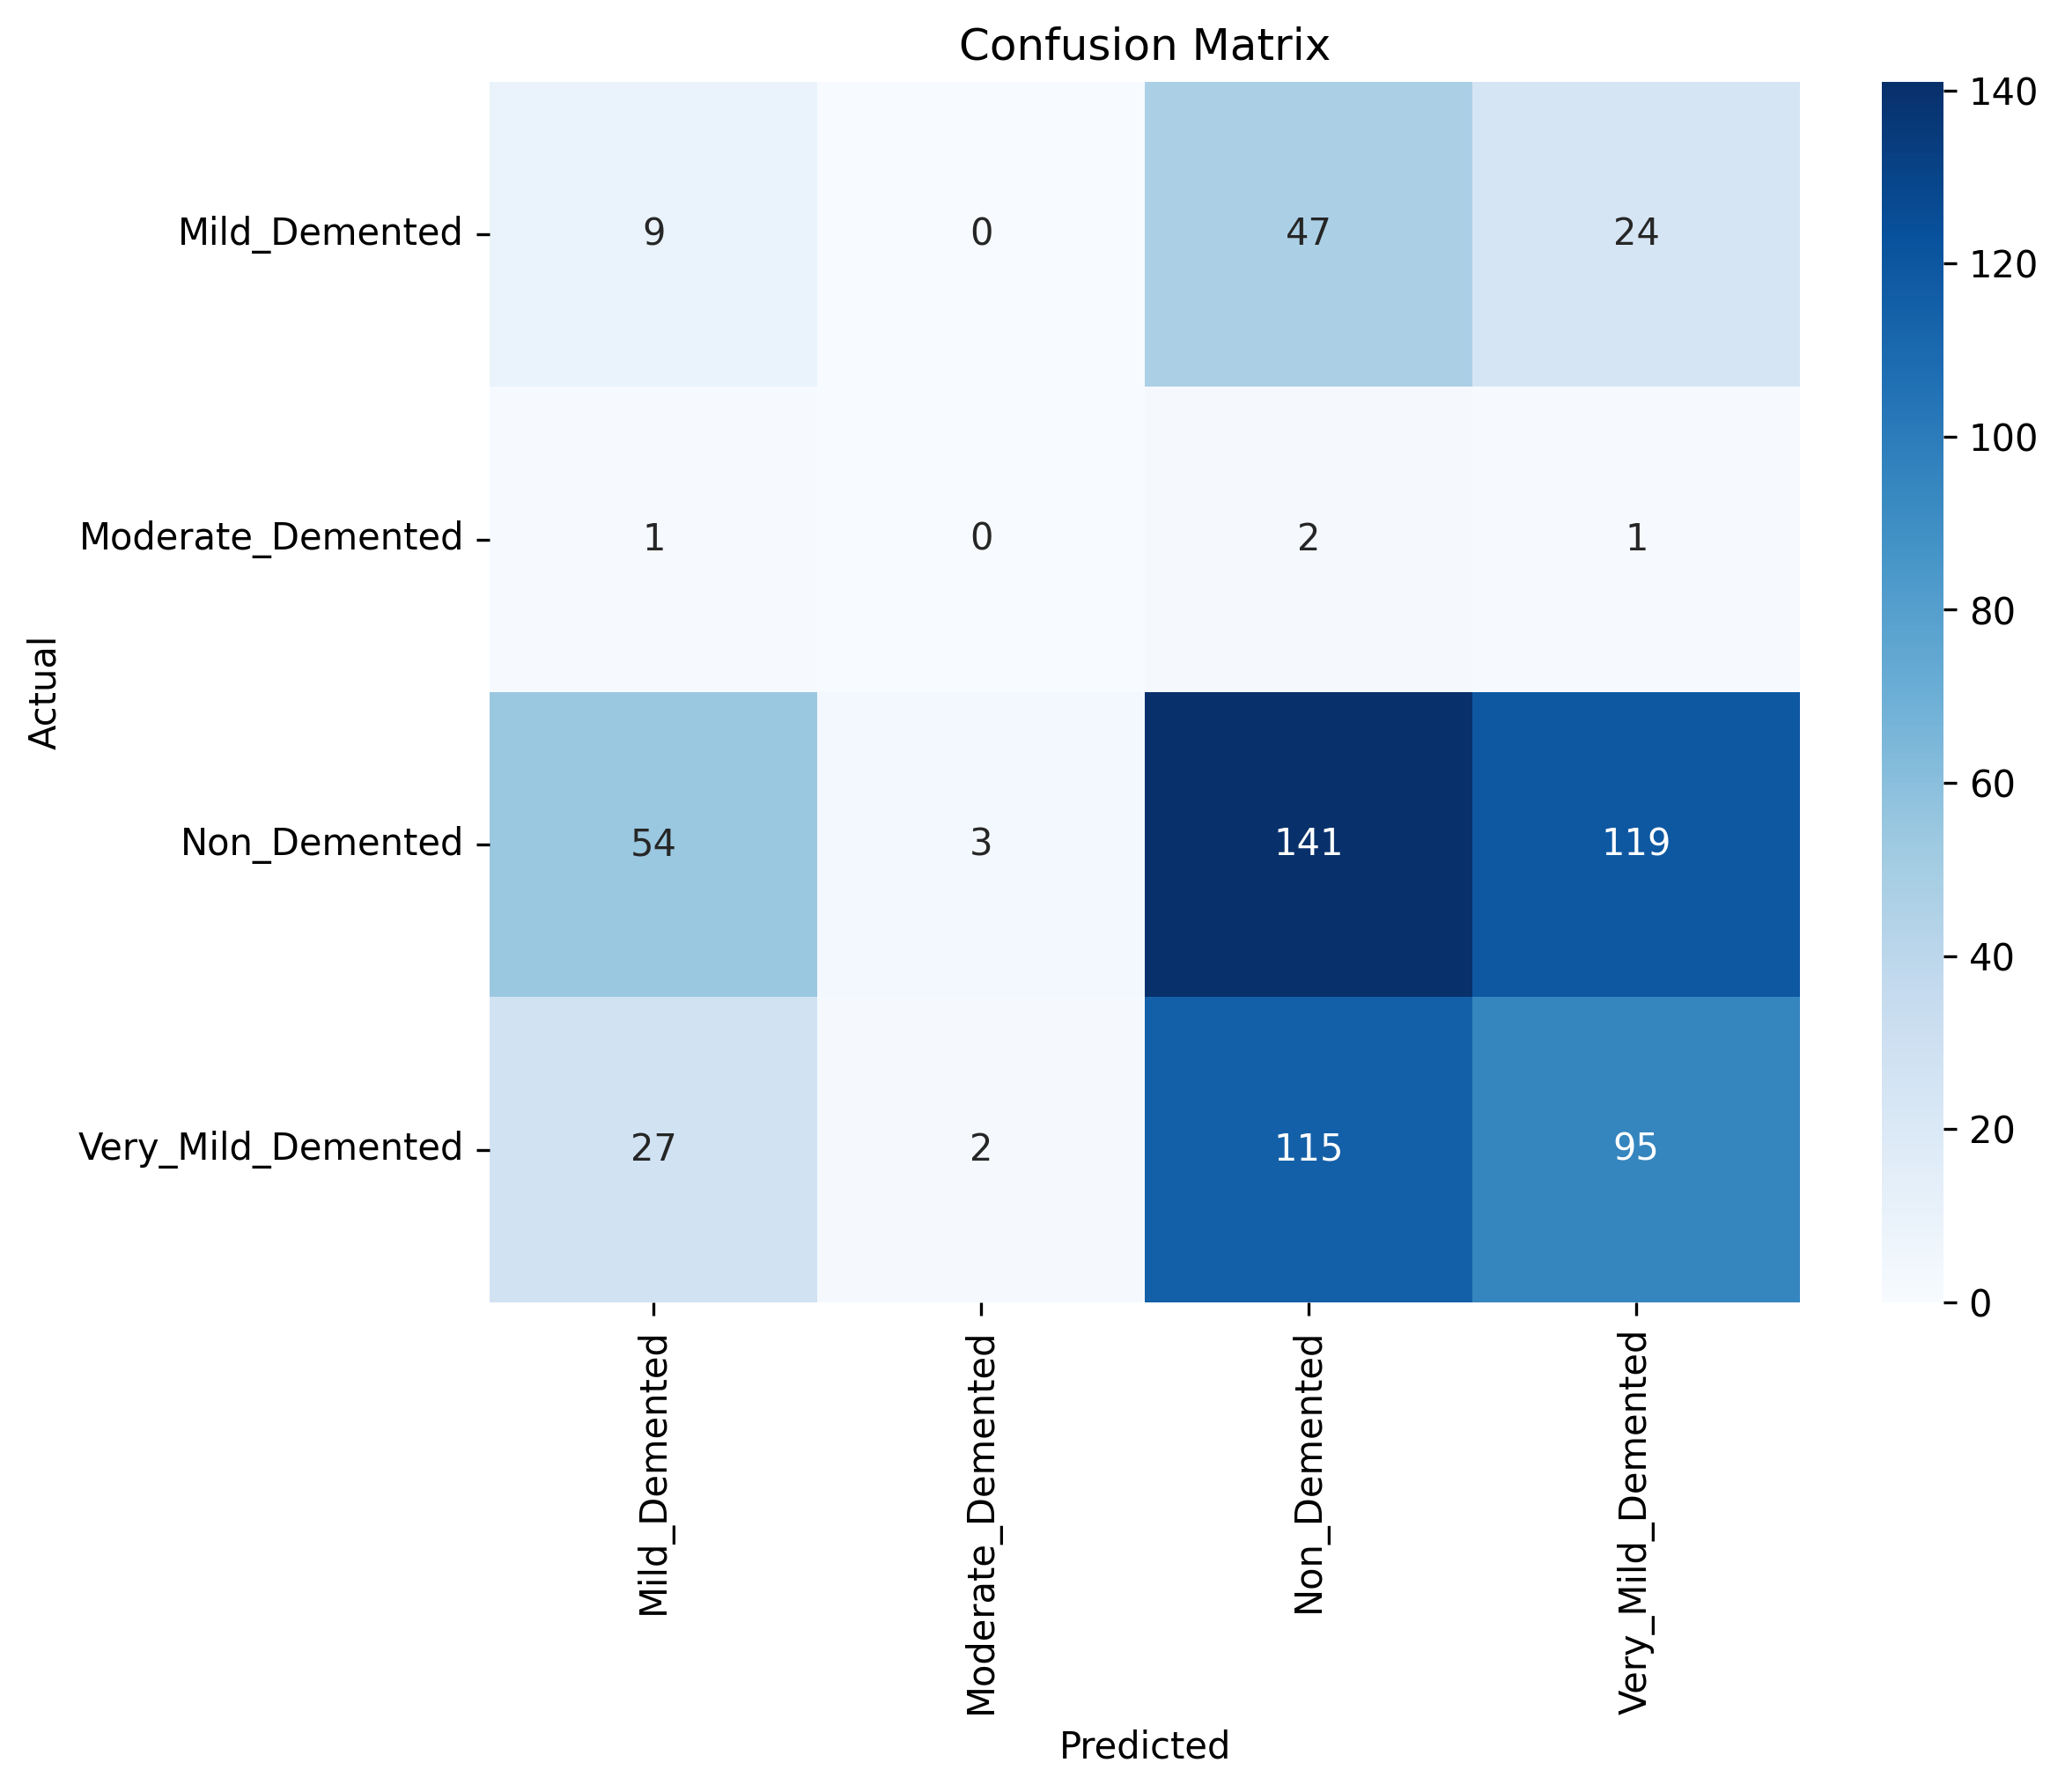

In [ ]:
# prompt: model evaluation

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming 'model' and 'test_data' are defined from the previous code
# Evaluate the model
loss, accuracy = model.evaluate(test_data)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


# Make predictions on the test data
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_data], axis=0)

# Generate and print the classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))


# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       0.90      0.98      0.93        81
 Moderate_Demented       1.00      1.00      1.00         6
      Non_Demented       0.99      0.94      0.96       309
Very_Mild_Demented       0.93      0.96      0.95       244

          accuracy                           0.95       640
         macro avg       0.95      0.97      0.96       640
      weighted avg       0.95      0.95      0.95       640



Text(286.1666666666666, 0.5, 'True')

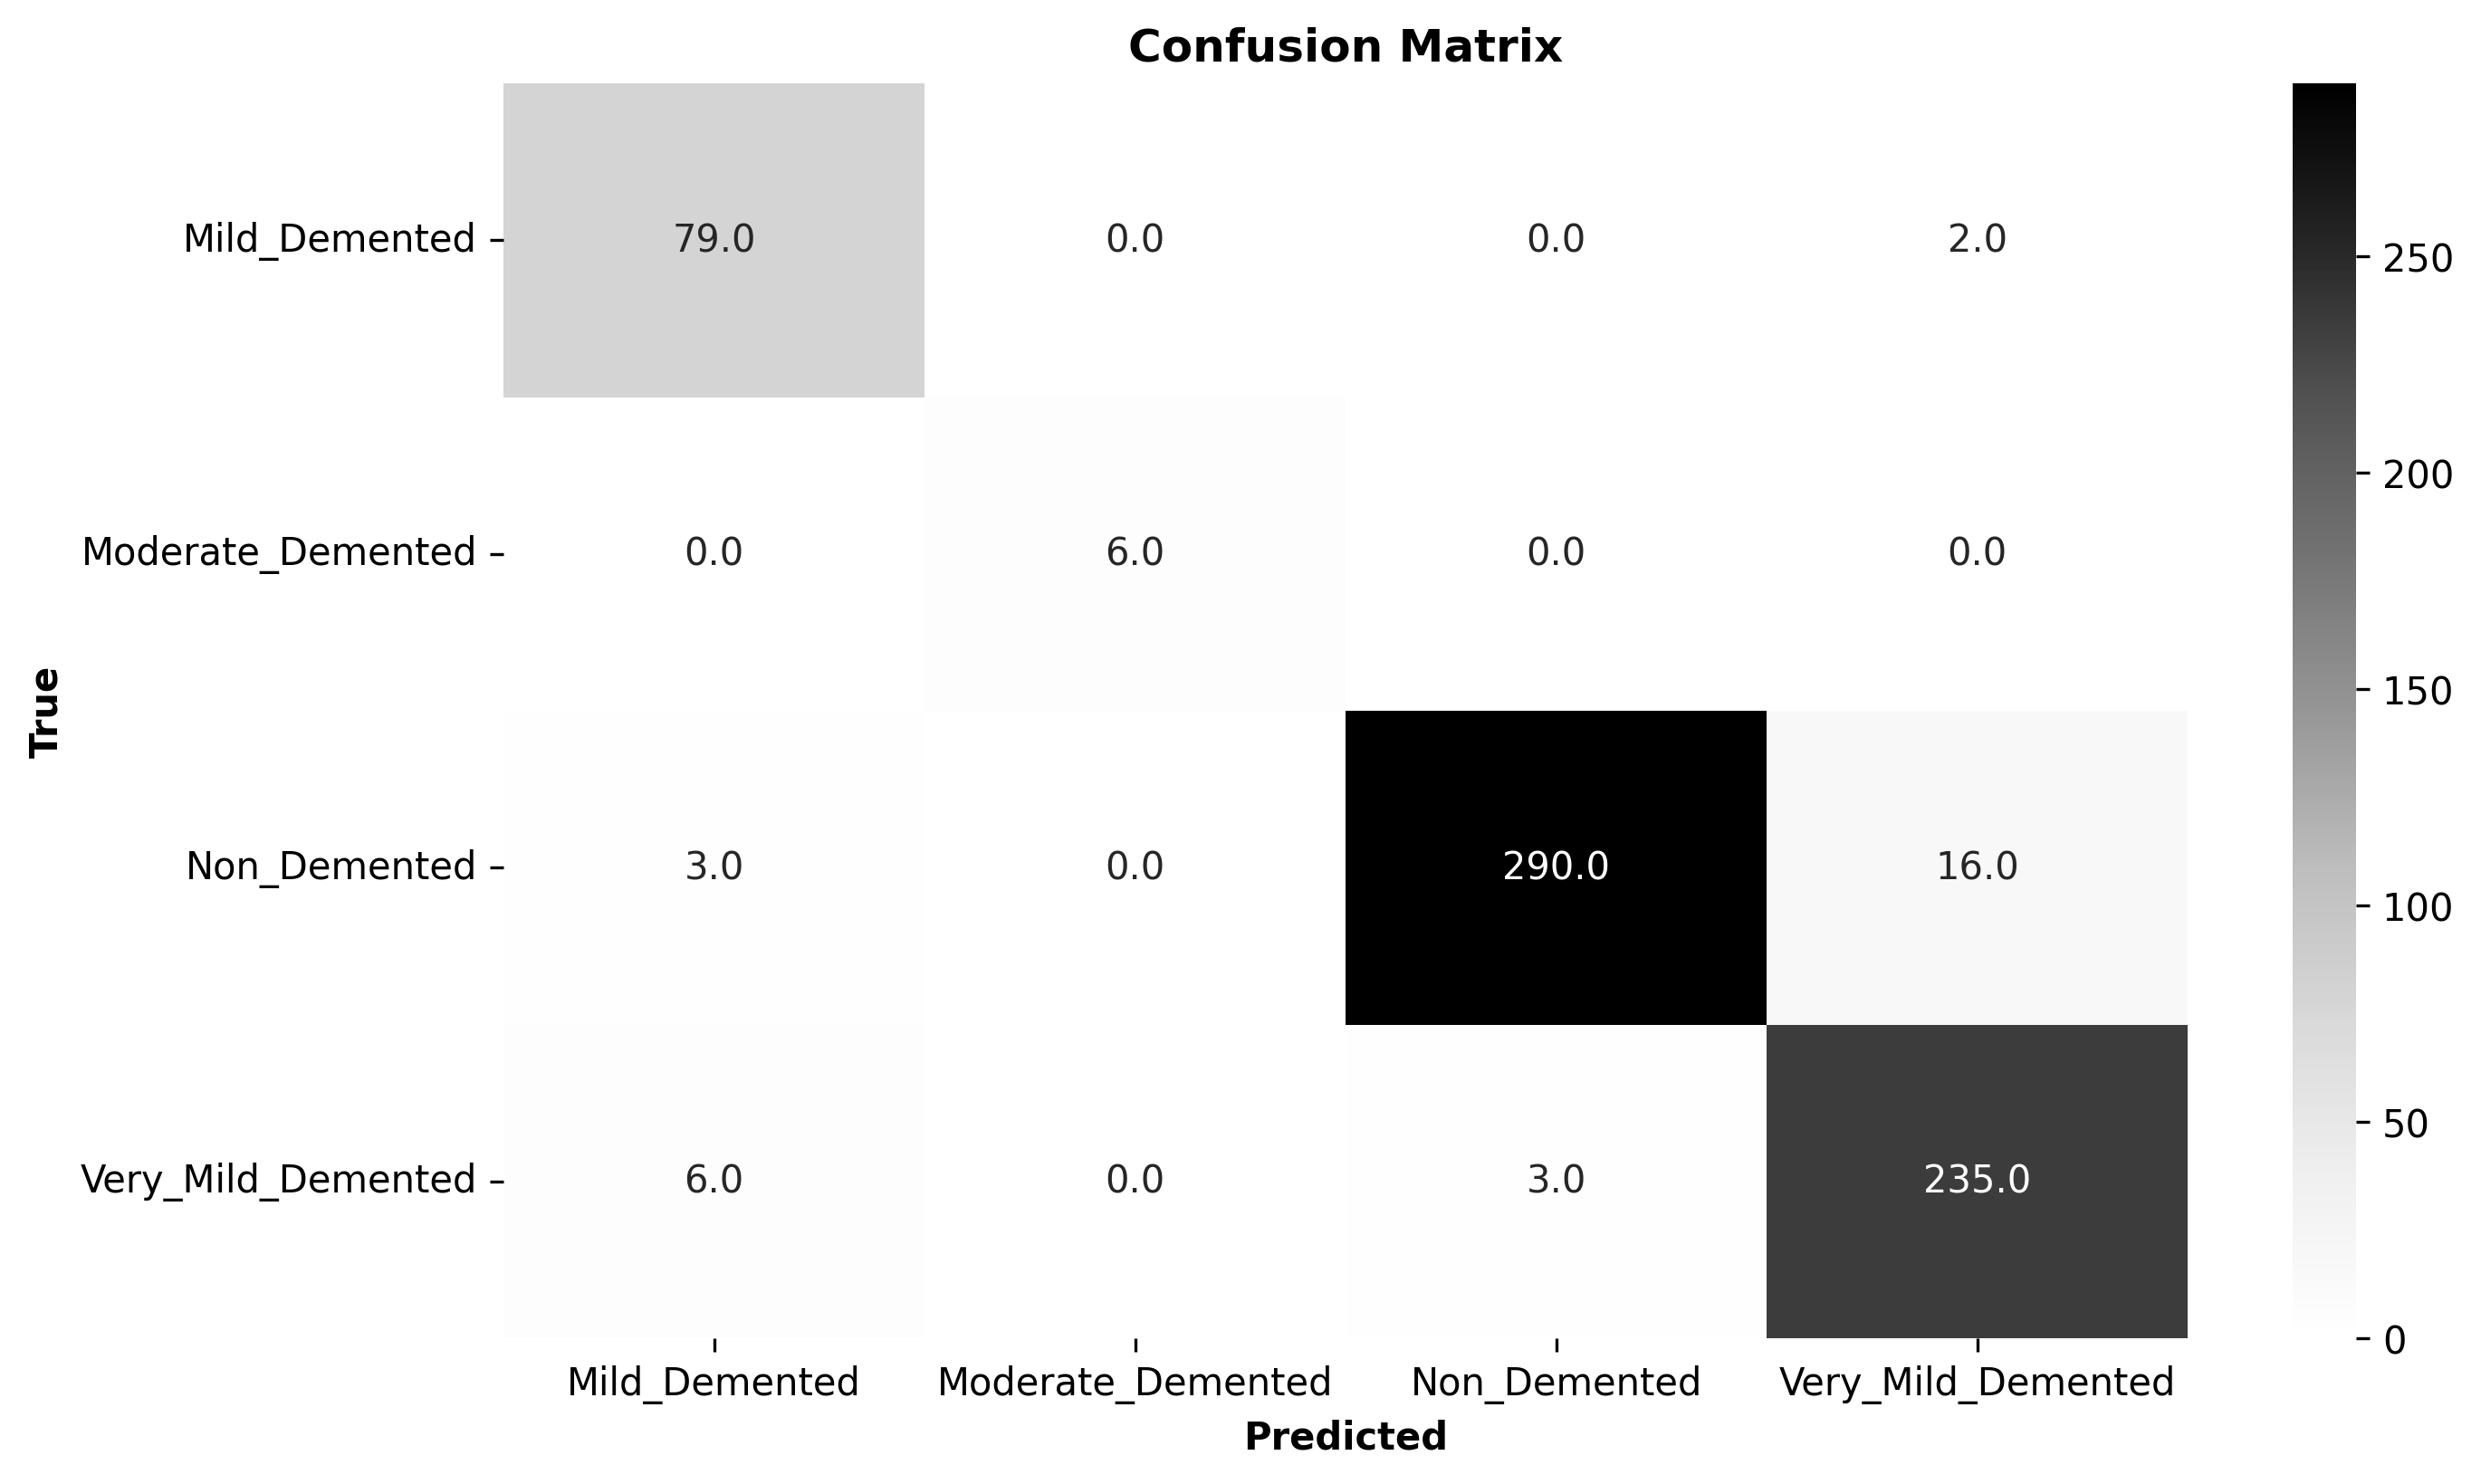

In [ ]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


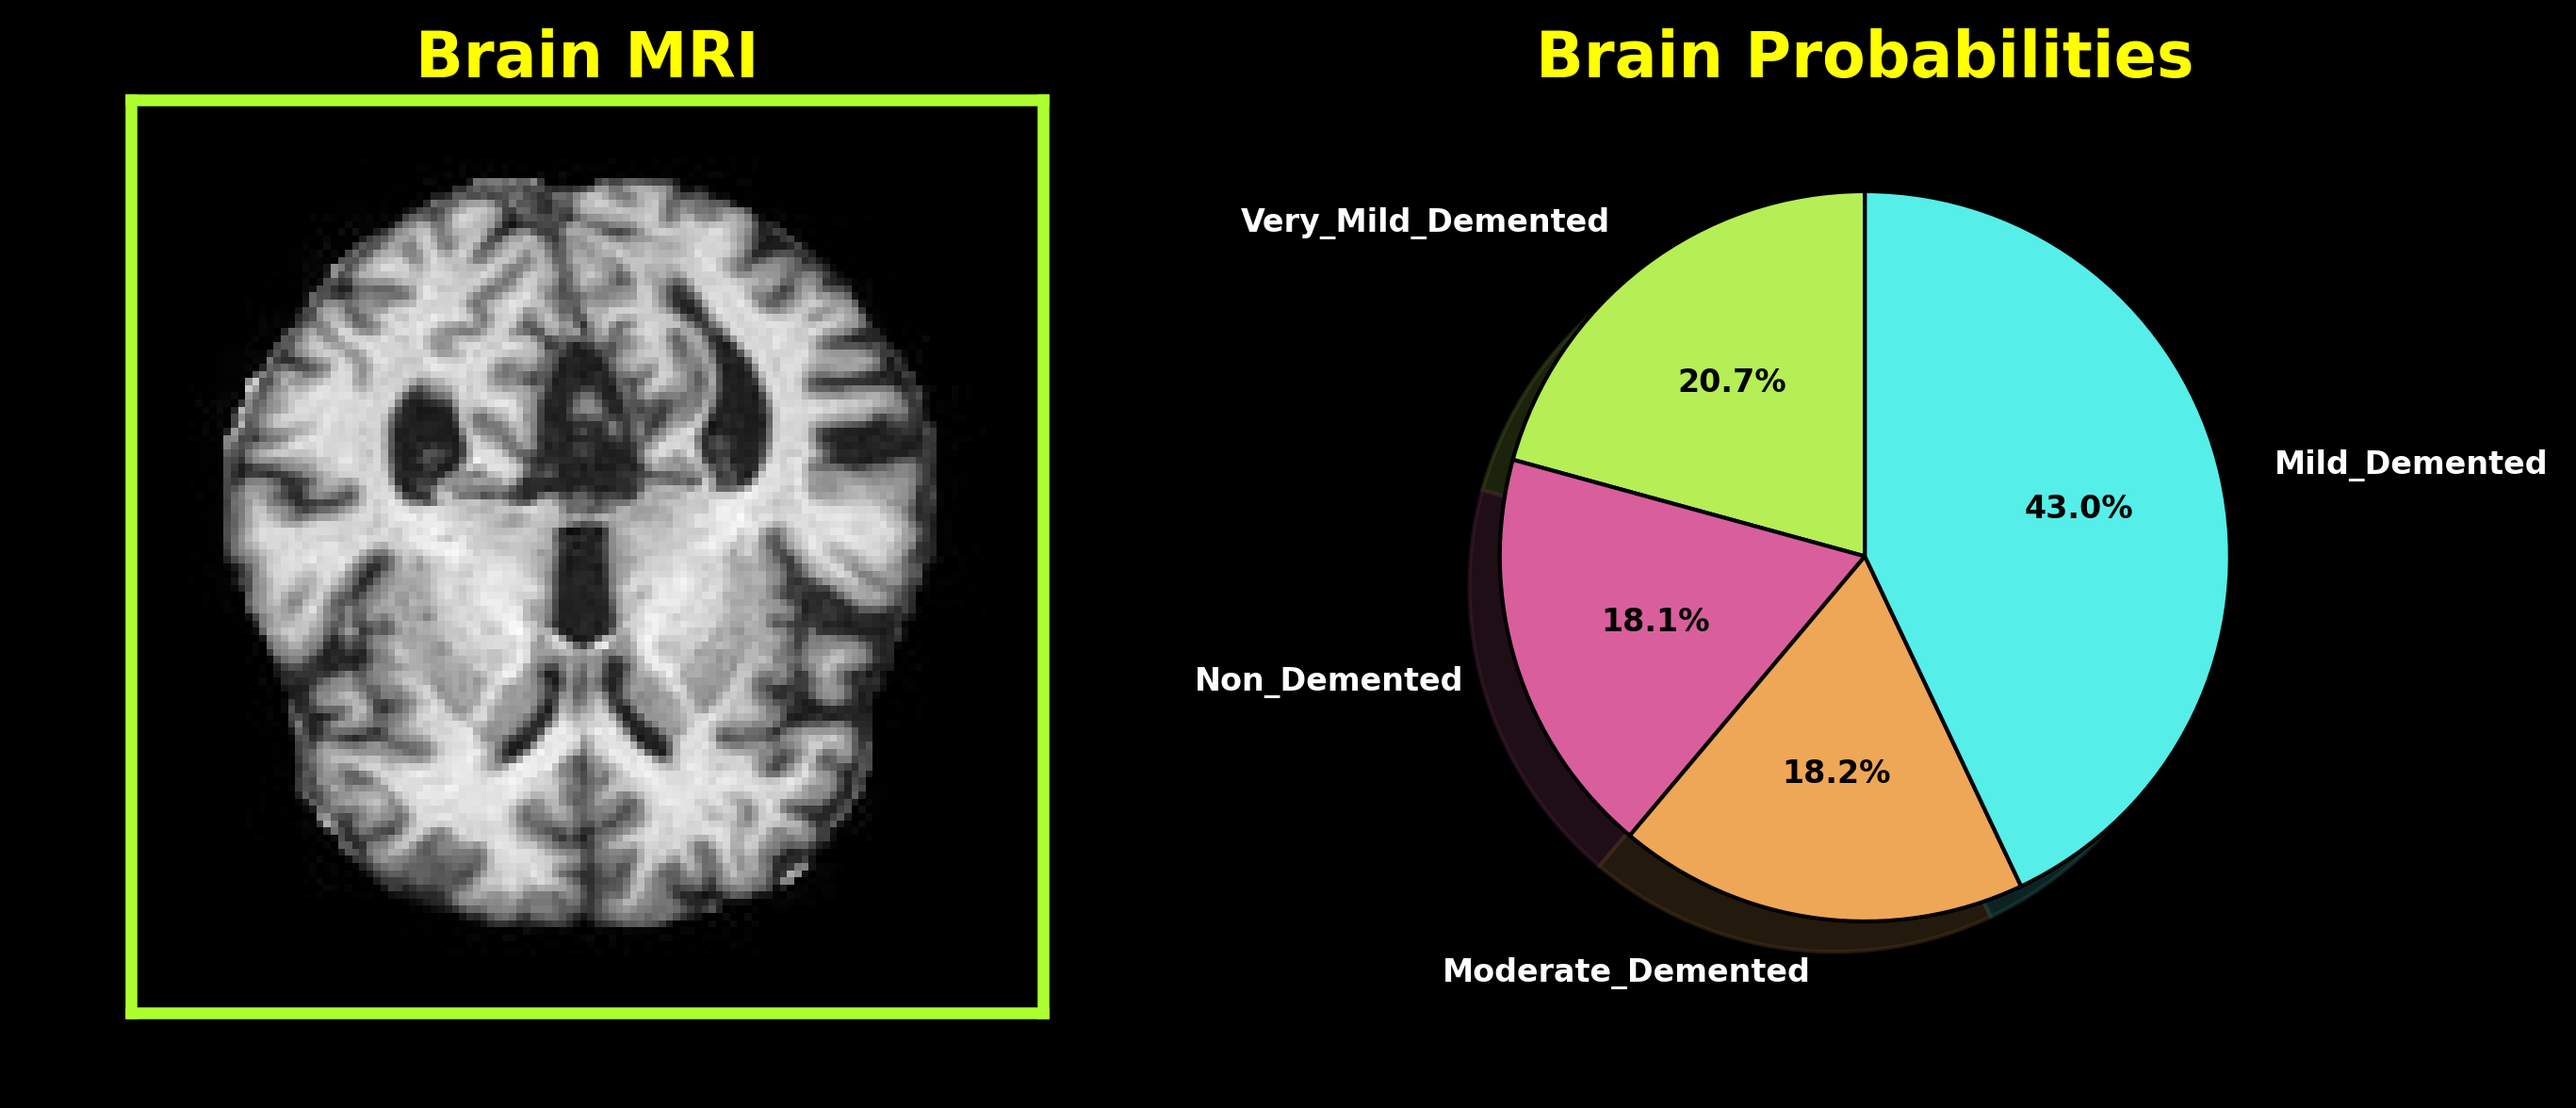

In [ ]:
def random_mri_prob_bringer(image_number=0):

    for images, _ in test_data.skip(5).take(1):
        image = images[image_number]
        pred = model.predict(tf.expand_dims(image, 0))[0]

    probs = list(tf.nn.softmax(pred).numpy())
    probs_dict = dict(zip(class_dist.keys(), probs))

    keys = list(probs_dict.keys())
    values = list(probs_dict.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='black')
    plt.subplots_adjust(wspace=0.4)
    ax1.imshow(image)
    ax1.set_title('Brain MRI', color="yellow", fontweight="bold", fontsize=16)

    edges = ['left', 'bottom', 'right', 'top']
    edge_color = "greenyellow"
    edge_width = 3
    for edge in edges:
        ax1.spines[edge].set_linewidth(edge_width)
        ax1.spines[edge].set_edgecolor(edge_color)

    plt.gca().axes.yaxis.set_ticklabels([])
    plt.gca().axes.xaxis.set_ticklabels([])

    wedges, labels, autopct = ax2.pie(values, labels=keys,  autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 8, "fontweight":"bold", "color":"white"},  wedgeprops=
       {'edgecolor':'black'} , labeldistance=1.15)

    for autotext in autopct:
        autotext.set_color('black')

    ax2.set_title('Brain Probabilities', color="yellow", fontweight="bold", fontsize=16)

rand_img_no = np.random.randint(1, 32)
random_mri_prob_bringer(image_number=rand_img_no)

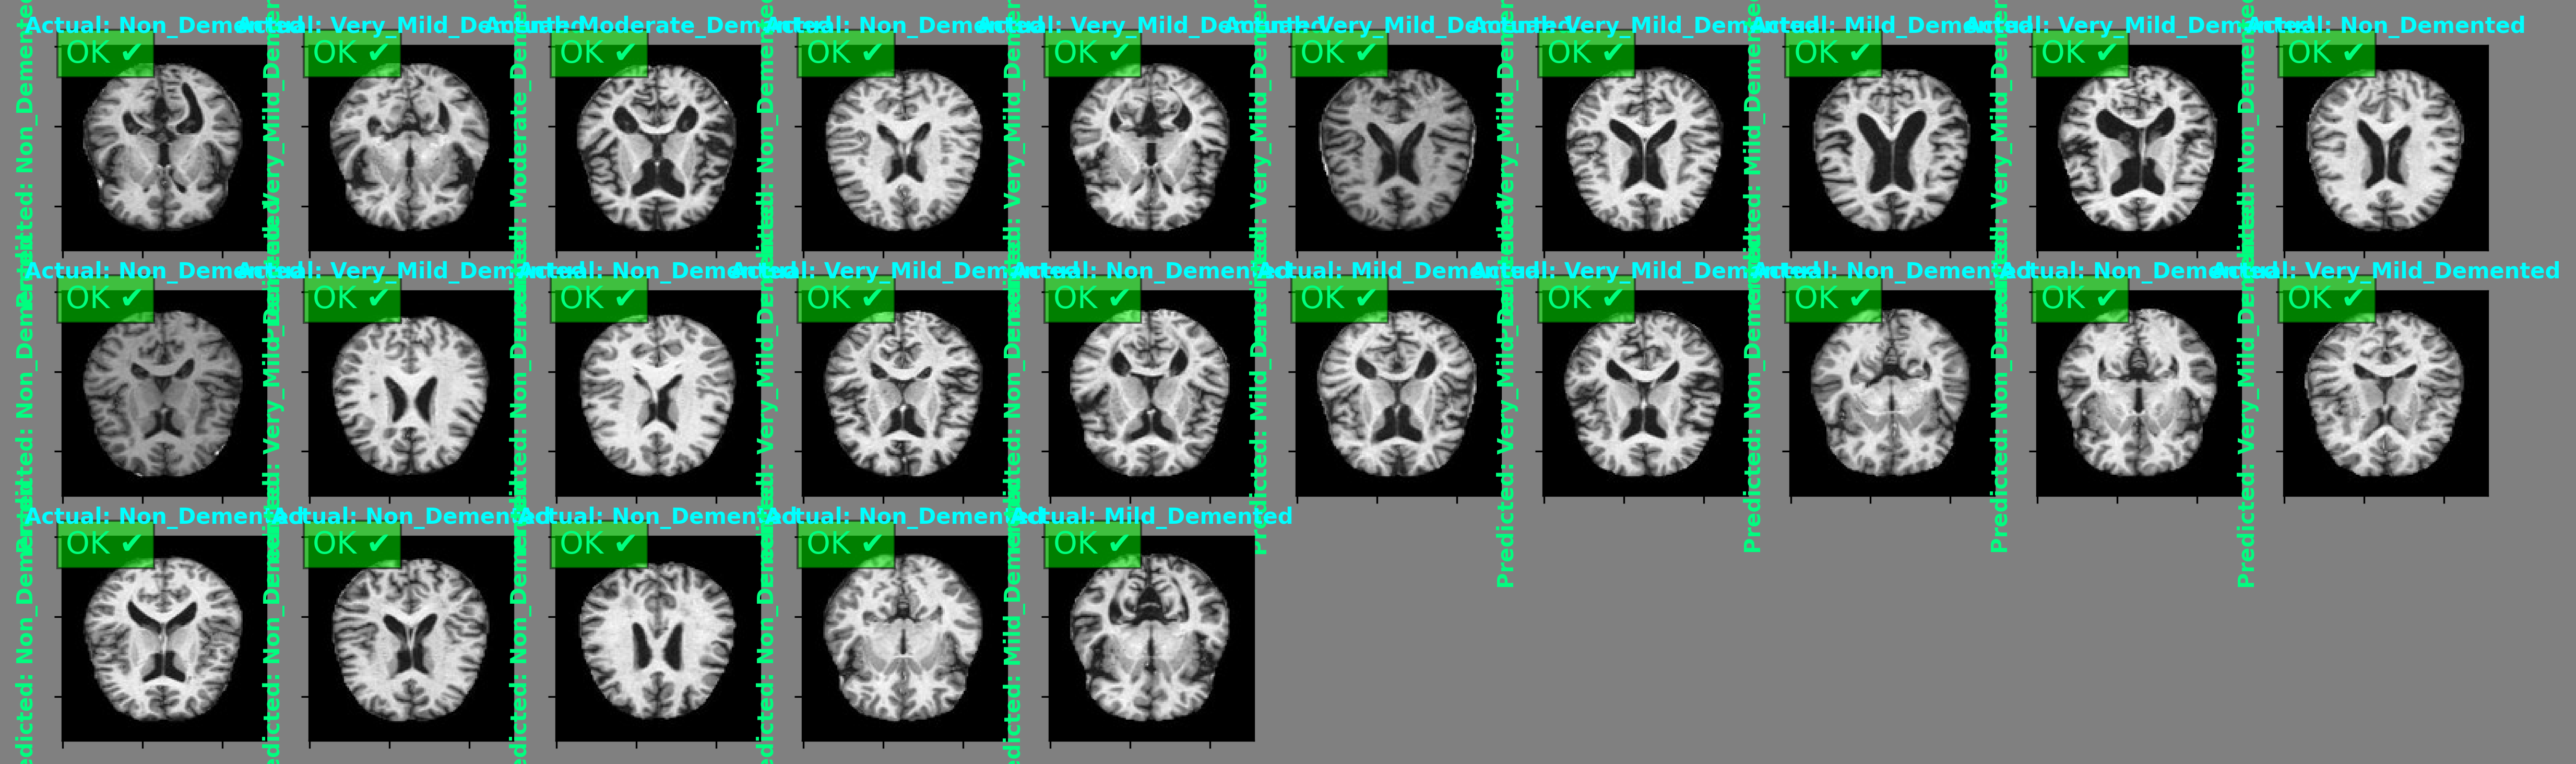

In [ ]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(10, 10, i + 1)
        plt.imshow(images[i])
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))

        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

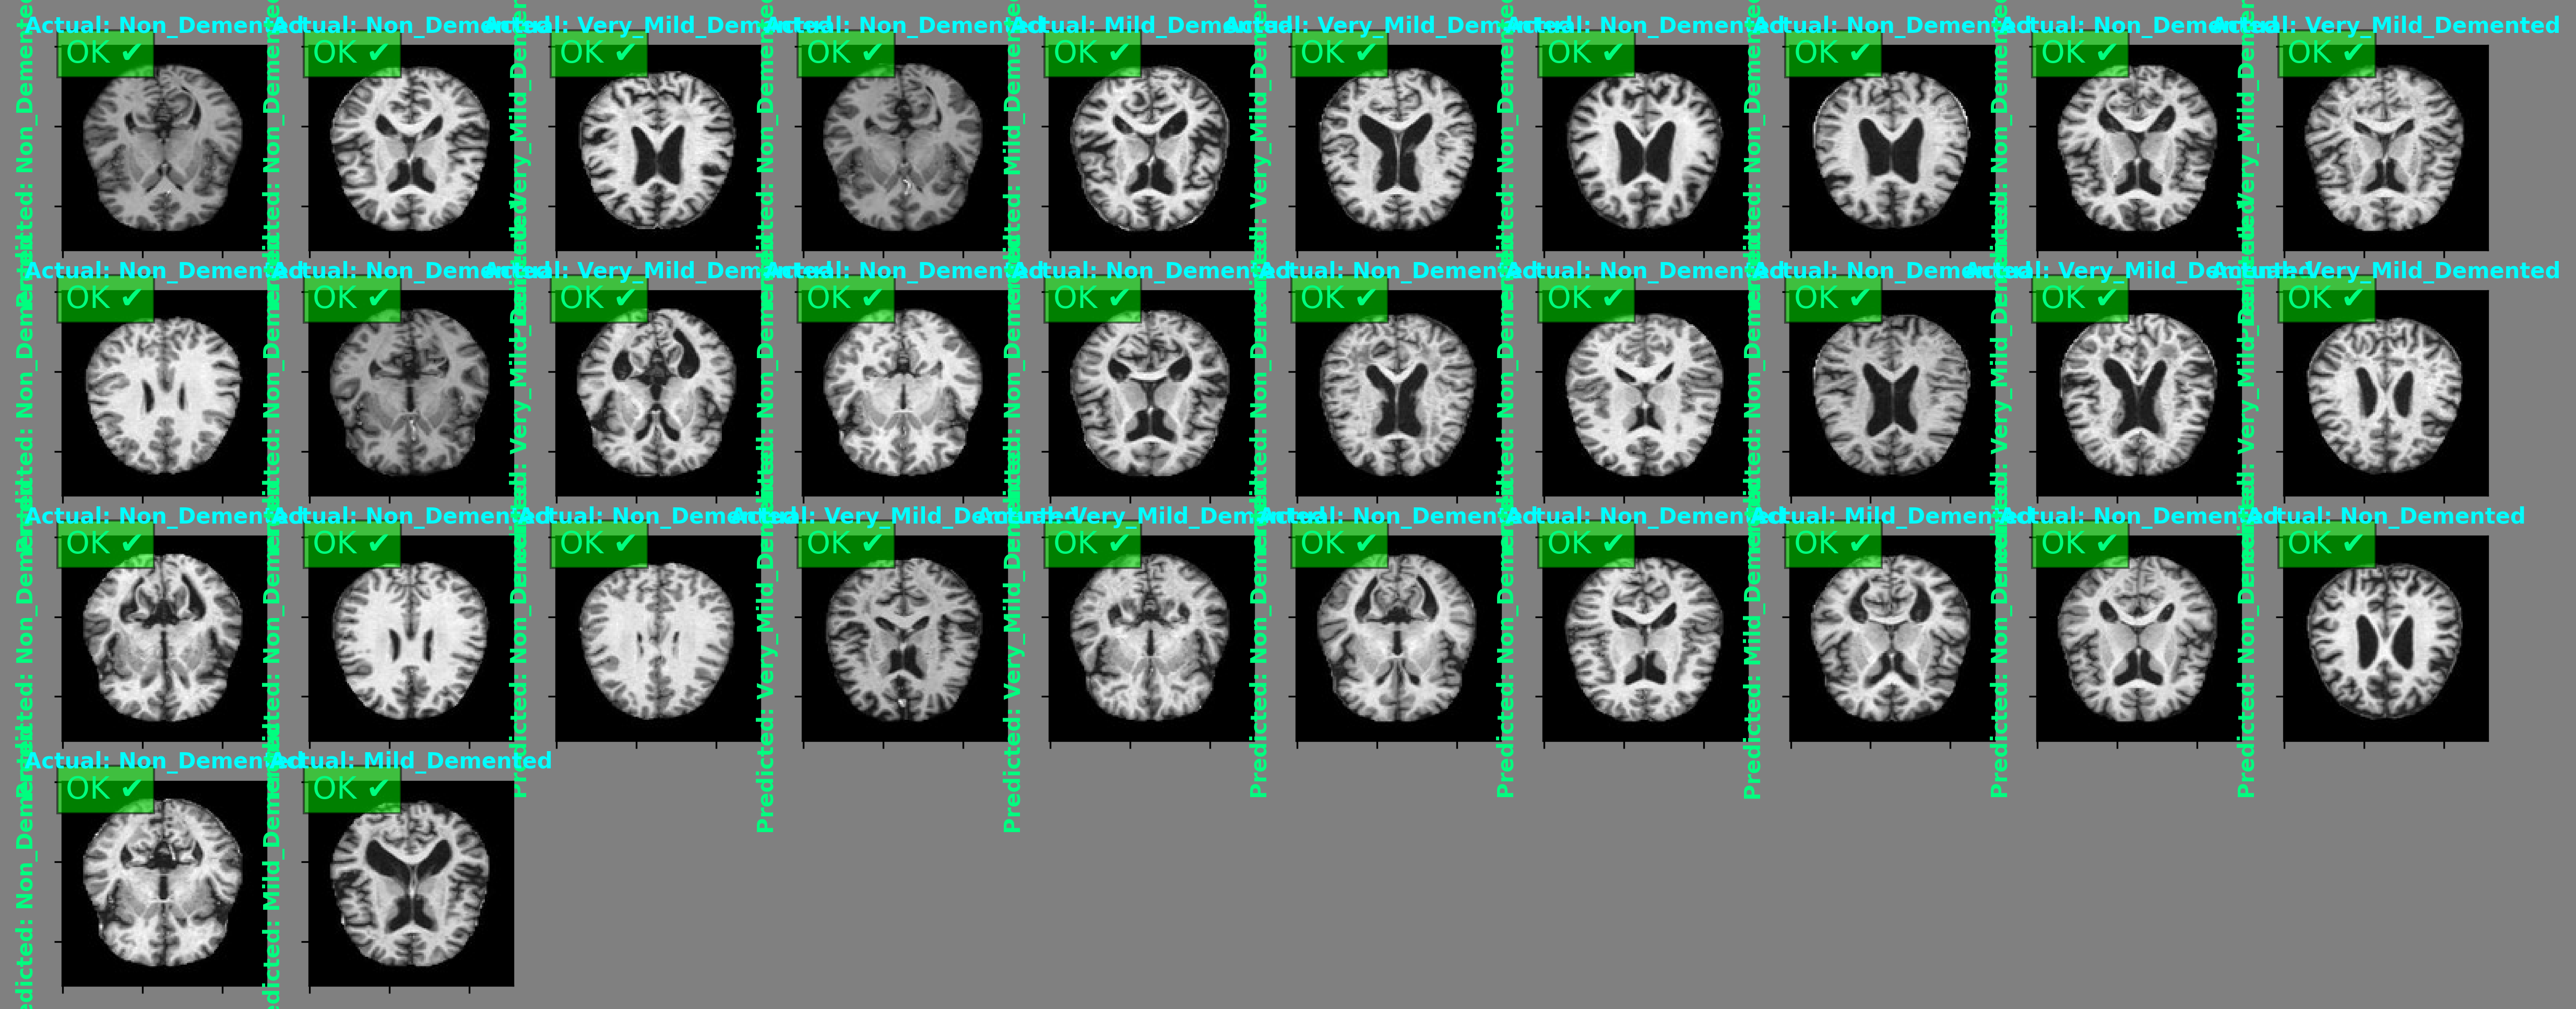

In [ ]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    # Get the number of images in the batch
    num_images = images.shape[0]
    # Iterate only over the available images
    for i in range(num_images):
        ax = plt.subplot(10, 10, i + 1)
        plt.imshow(images[i])
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))

        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

In [ ]:
# prompt: Comparing Predicted Classes with the Actual Classes from the Test Data with 100 samples

import pandas as pd
import numpy as np
# Assuming 'test_data', 'model', and 'class_names' are defined from the previous code

# Sample 100 images from the test data
sample_test_data = test_data.take(100)

# Make predictions on the sample test data
y_pred = []
y_true = []
for images, labels in sample_test_data:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_pred.extend(predicted_classes)
    y_true.extend(labels.numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Print the comparison of predicted and actual classes
comparison_df = pd.DataFrame({'Actual Class': y_true, 'Predicted Class': y_pred})
print(comparison_df)

# Calculate and print classification metrics for the sample
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
     Actual Class  Predicted Class
0               2                2
1               3                3
2               3                3
3               2                3
4               2                2
..        

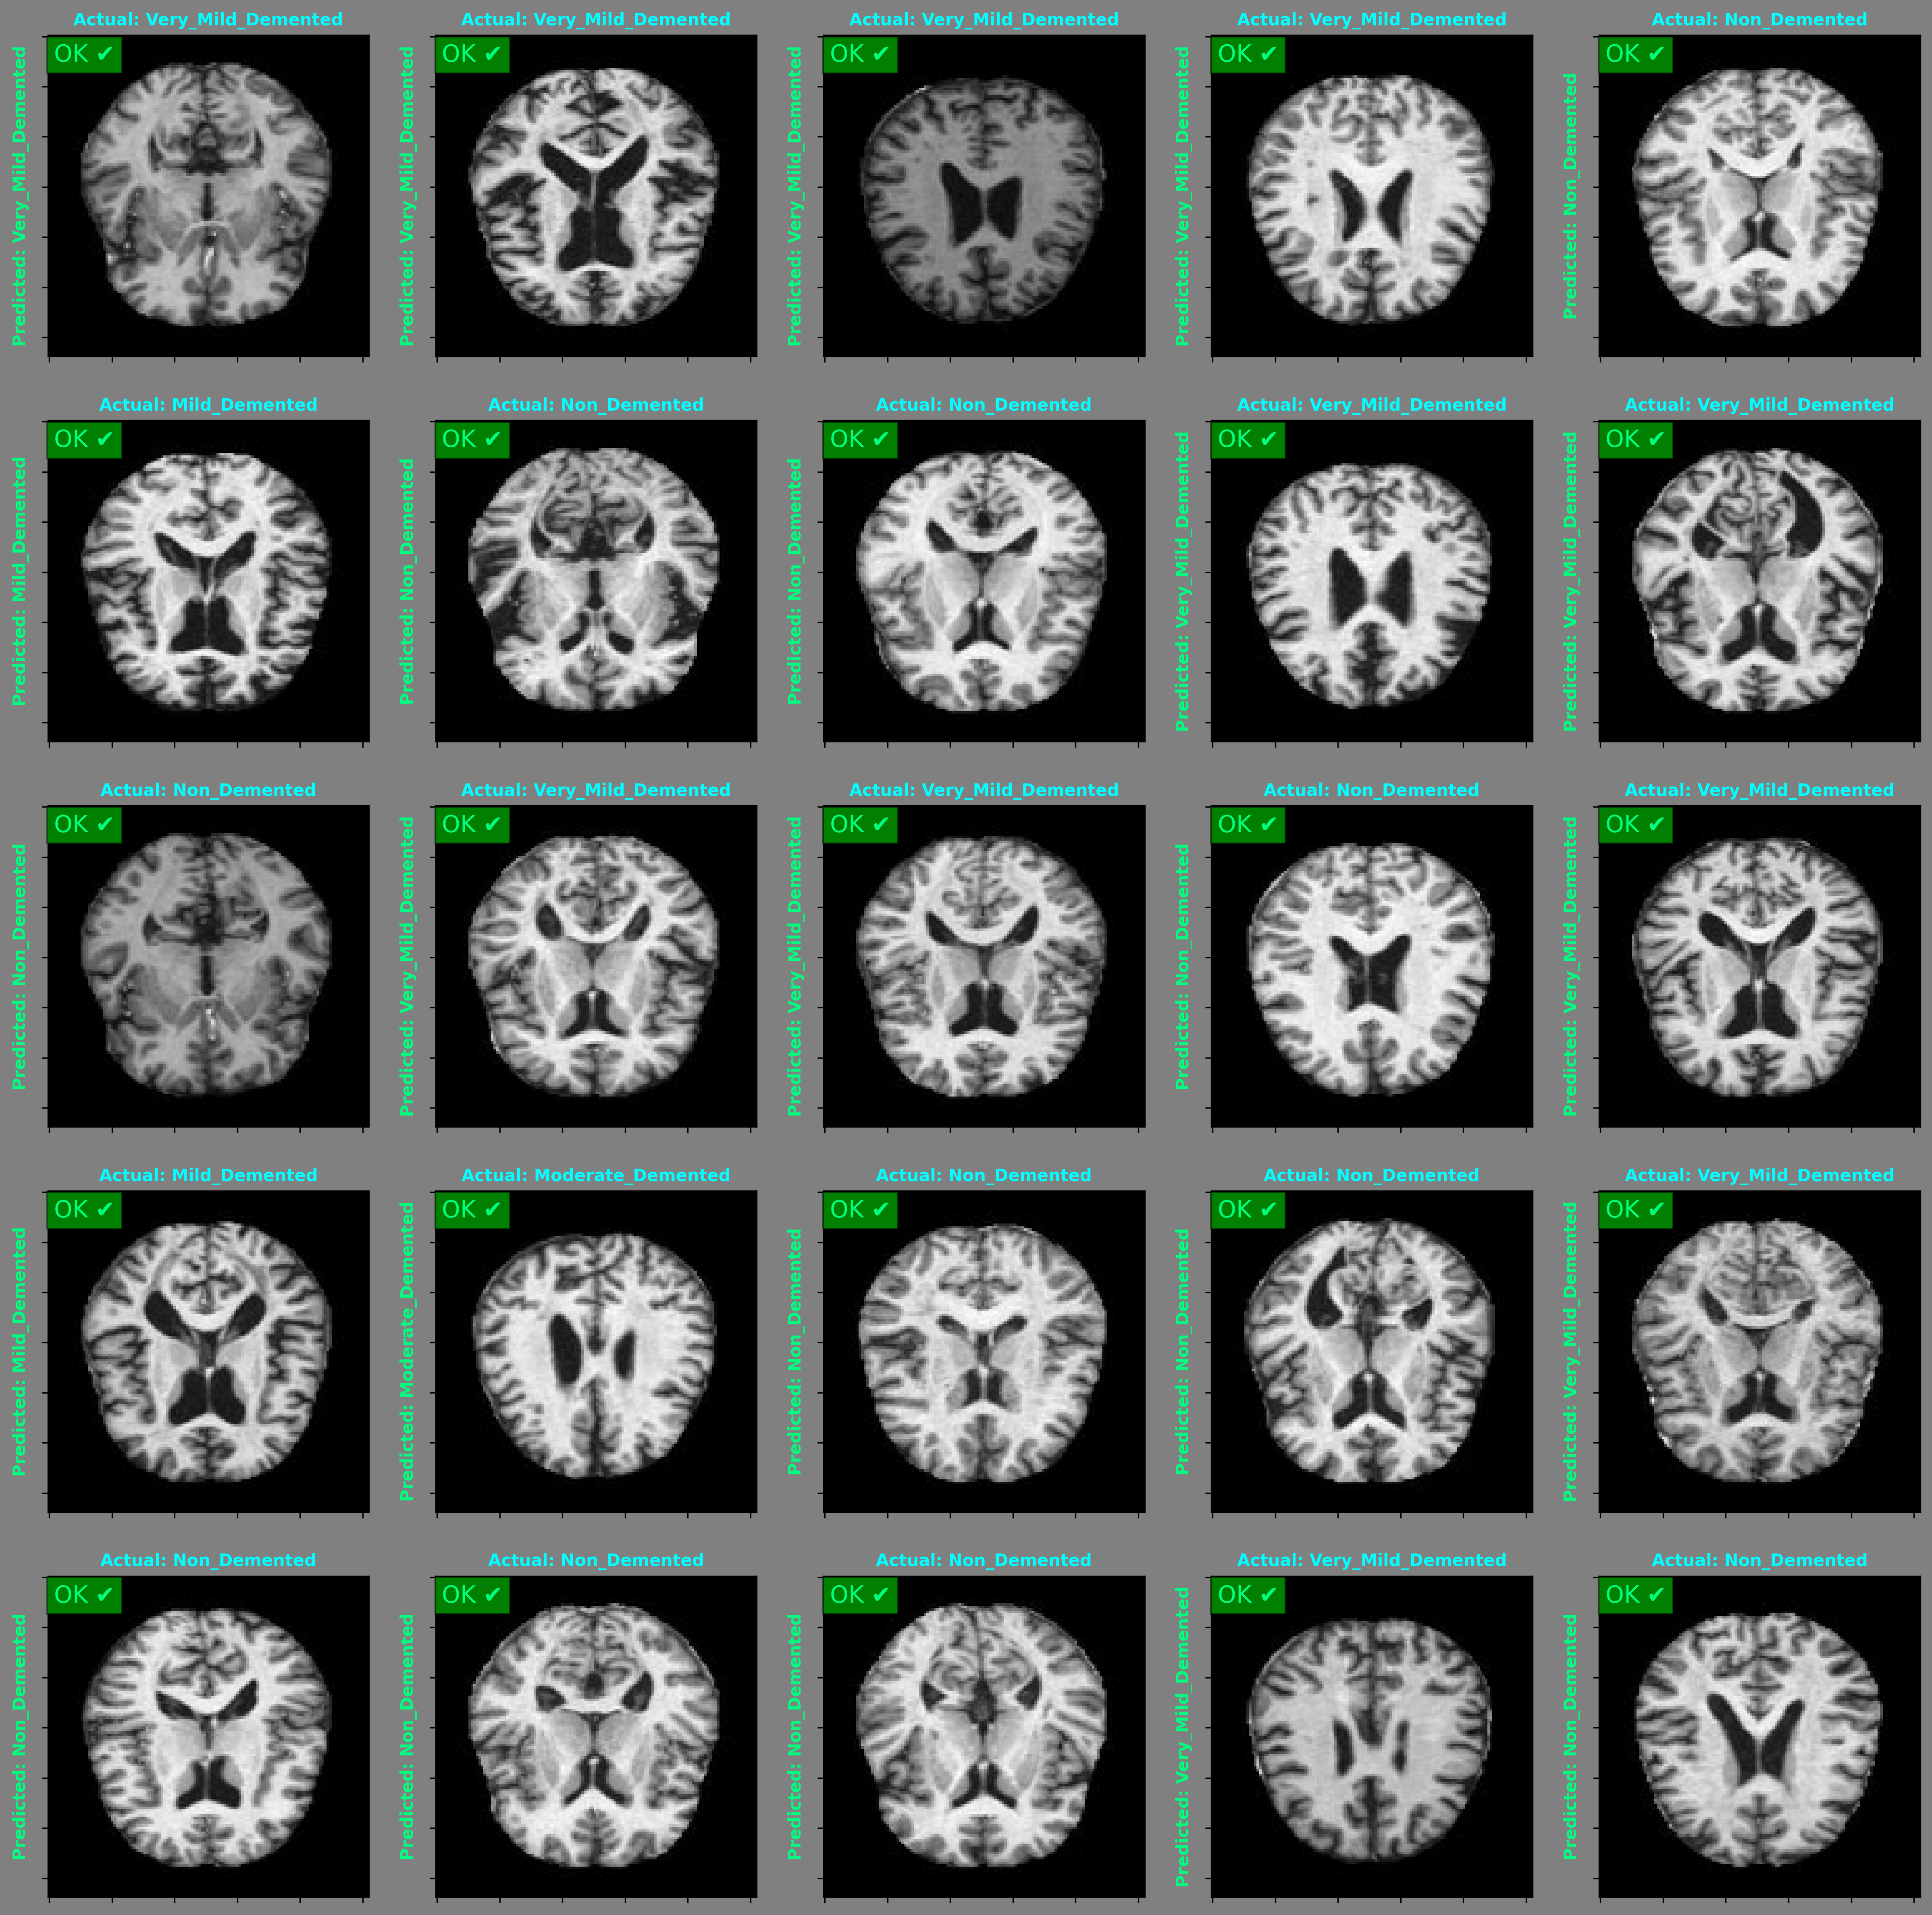

In [ ]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))

        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

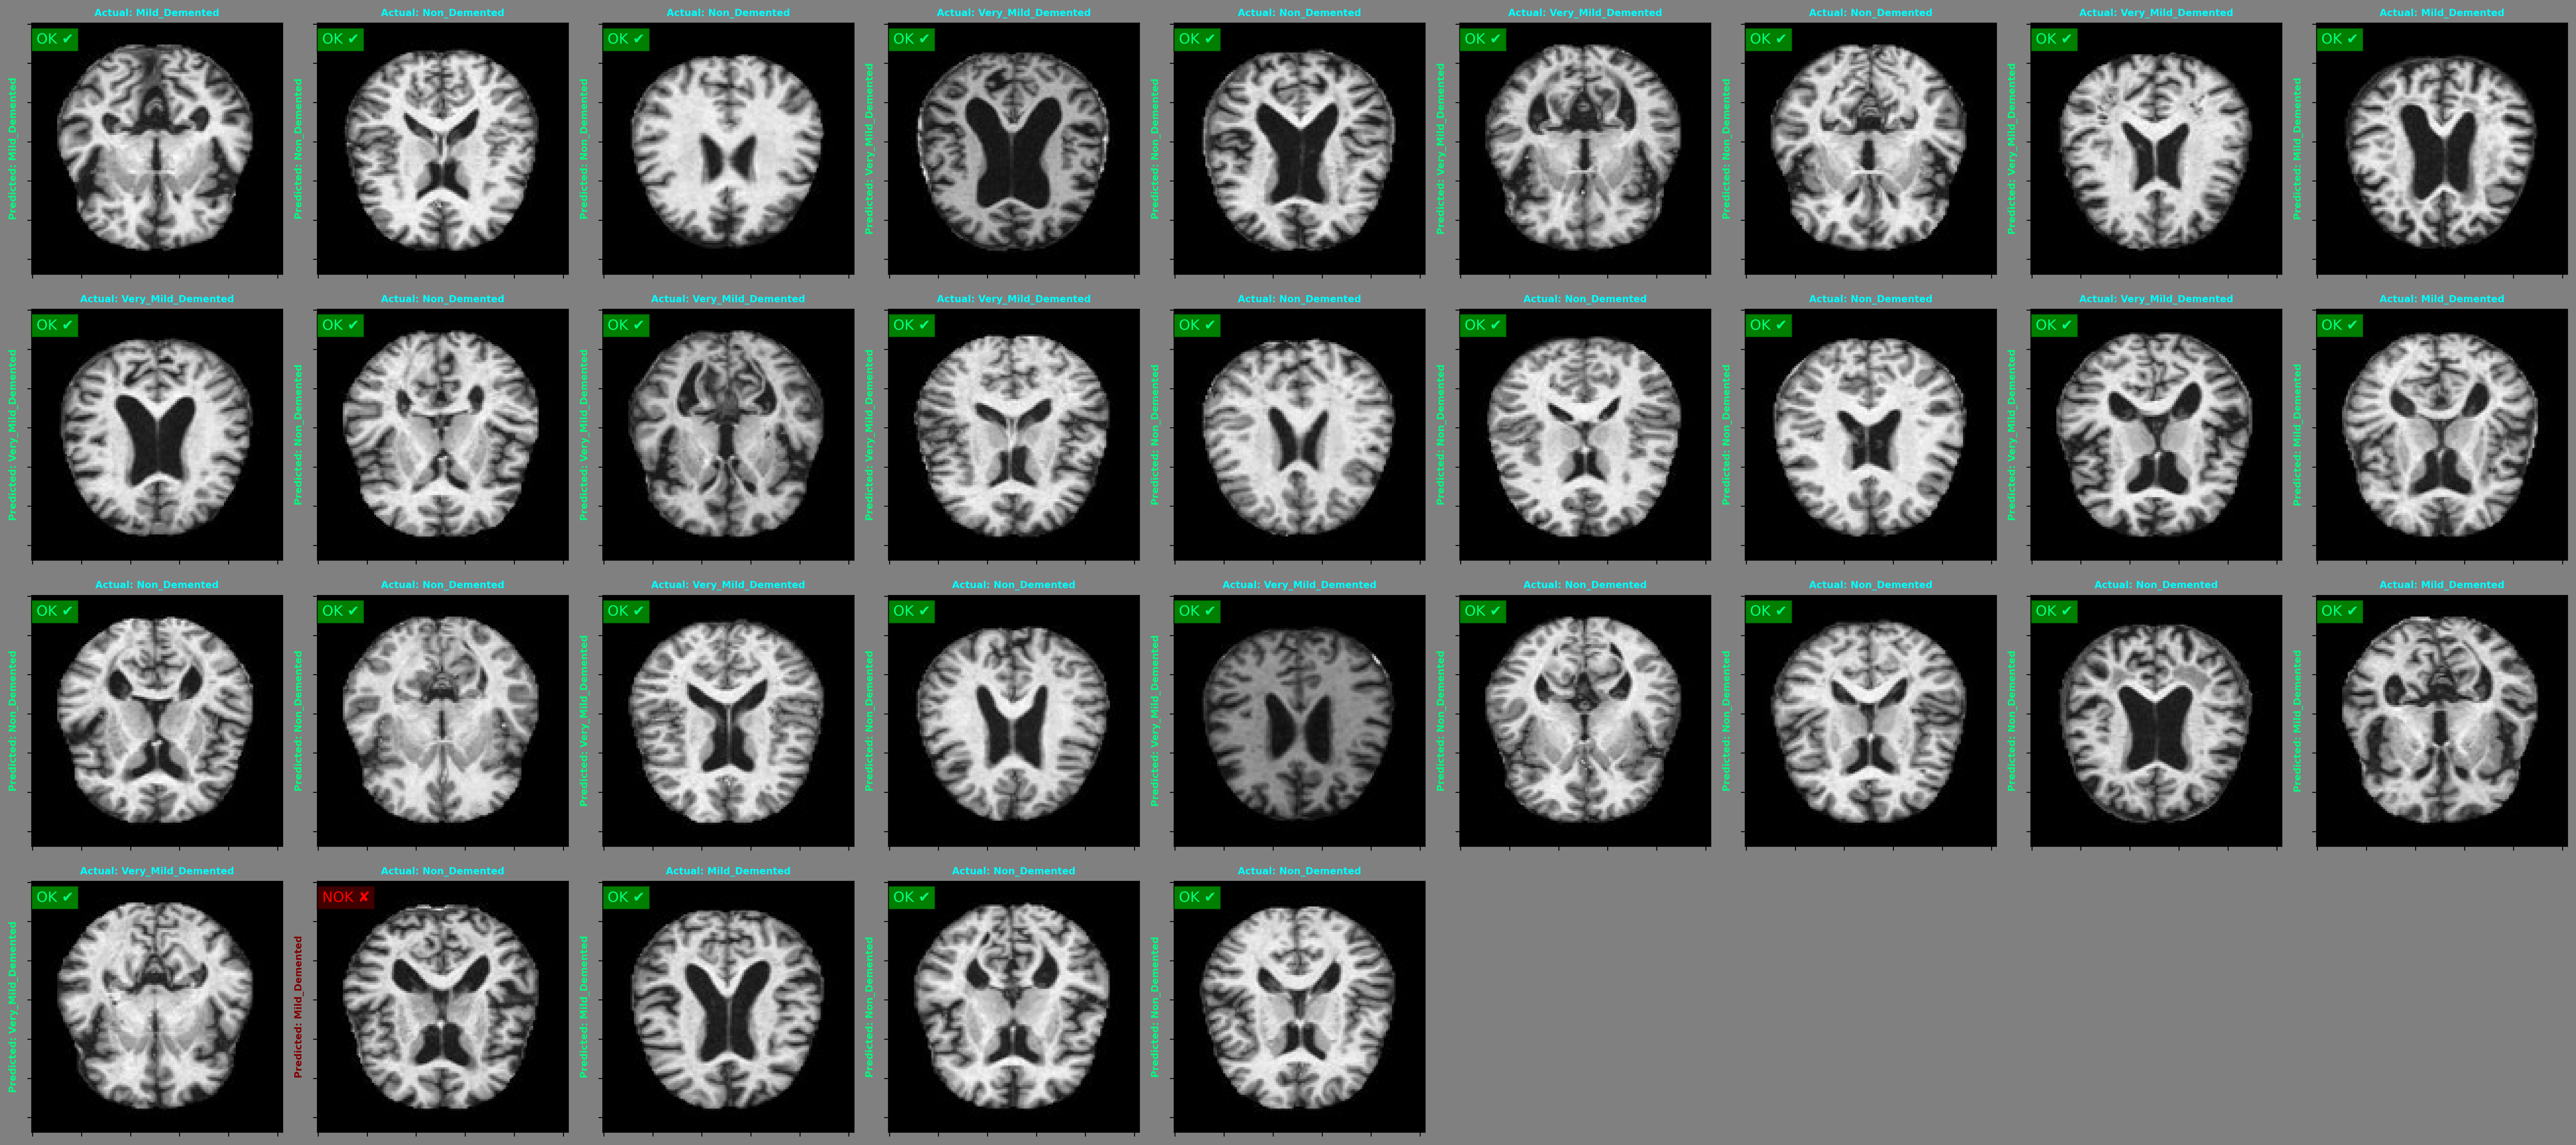

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

plt.figure(figsize=(30, 30), facecolor="gray")

for images, labels in test_data.take(1):  # Taking one batch of test images
    num_images = images.shape[0]  # Get the actual number of images in the batch
    for i in range(num_images):  # Loop through the available images only
        ax = plt.subplot(9, 9, i + 1)  # Create a 9x9 grid
        plt.imshow(images[i])

        # Model prediction
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])

        actual_label = class_names[labels[i]]
        predicted_label = class_names[np.argmax(score)]

        # Set title and color based on correctness
        if actual_label == predicted_label:
            plt.title(f"Actual: {actual_label}", color="aqua", fontweight="bold", fontsize=8)
            plt.ylabel(f"Predicted: {predicted_label}", color="springgreen", fontweight="bold", fontsize=8)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=12)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))
        else:
            plt.title(f"Actual: {actual_label}", color="aqua", fontweight="bold", fontsize=8)
            plt.ylabel(f"Predicted: {predicted_label}", color="maroon", fontweight="bold", fontsize=8)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=12)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))

        # Hide axis labels
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

plt.tight_layout()  # Adjust layout to fit better
plt.show()

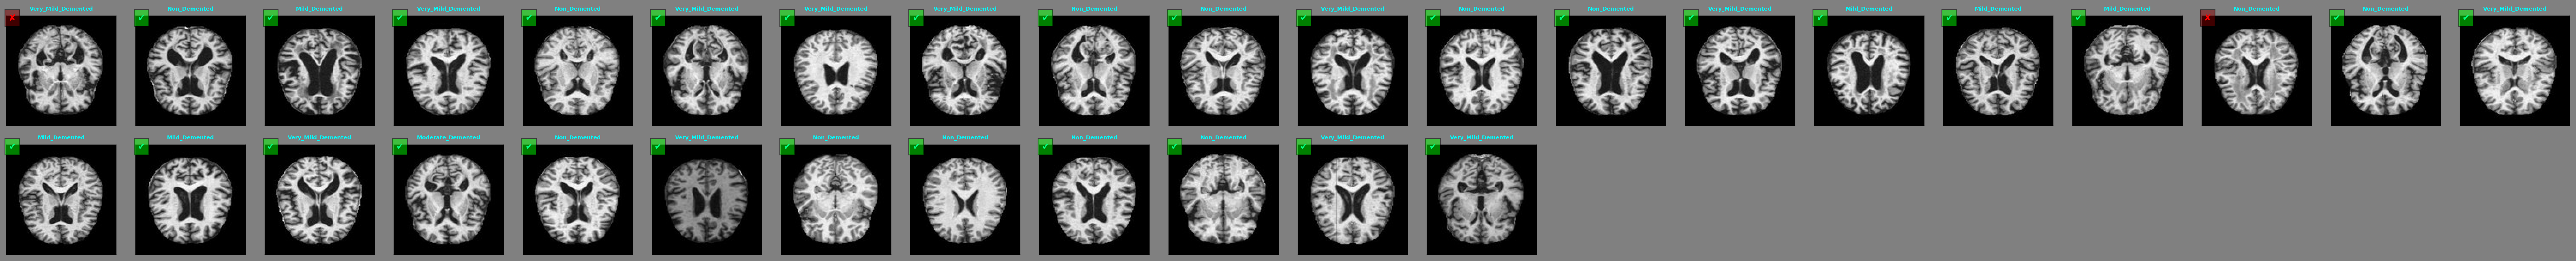

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

plt.figure(figsize=(40, 20), facecolor="gray")

for images, labels in test_data.take(1):
    num_images = min(200, images.shape[0])  # Ensure we don't exceed available images

    for i in range(num_images):
        ax = plt.subplot(10, 20, i + 1)
        plt.imshow(images[i])

        # Model prediction
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])

        actual_label = class_names[labels[i]]
        predicted_label = class_names[np.argmax(score)]

        # Set title and color based on correctness
        if actual_label == predicted_label:
            plt.title(f"{actual_label}", color="aqua", fontweight="bold", fontsize=6)
            plt.ylabel(f"{predicted_label}", color="springgreen", fontweight="bold", fontsize=6)
            ok_text = plt.text(2, 5, "✔", color="springgreen", fontsize=10)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))
        else:
            plt.title(f"{actual_label}", color="aqua", fontweight="bold", fontsize=6)
            plt.ylabel(f"{predicted_label}", color="maroon", fontweight="bold", fontsize=6)
            nok_text = plt.text(2, 5, "✘", color="red", fontsize=10)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))

        # Hide axis labels
        plt.gca().axes.xaxis.set_visible(False)
        plt.gca().axes.yaxis.set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
for images, labels in test_data.take(11):
    print(f"Batch size: {images.shape[0]}")


Batch size: 32
Batch size: 32
Batch size: 32
Batch size: 32
Batch size: 32
Batch size: 32
Batch size: 32
Batch size: 32
Batch size: 32
Batch size: 32
Batch size: 32


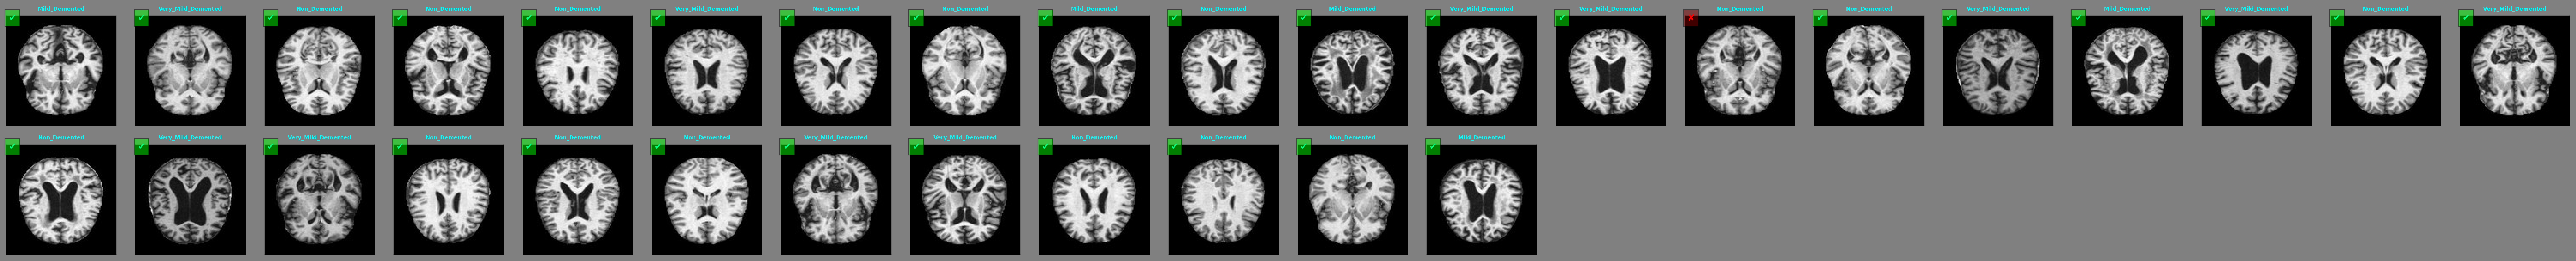

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

plt.figure(figsize=(40, 20), facecolor="gray")

for images, labels in test_data.take(1):
    num_images = min(200, images.shape[0])  # Ensure we don't exceed available images

    for i in range(num_images):
        ax = plt.subplot(10, 20, i + 1)
        plt.imshow(images[i])

        # Model prediction
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])

        actual_label = class_names[labels[i]]
        predicted_label = class_names[np.argmax(score)]

        # Set title and color based on correctness
        if actual_label == predicted_label:
            plt.title(f"{actual_label}", color="aqua", fontweight="bold", fontsize=6)
            plt.ylabel(f"{predicted_label}", color="springgreen", fontweight="bold", fontsize=6)
            ok_text = plt.text(2, 5, "✔", color="springgreen", fontsize=10)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))
        else:
            plt.title(f"{actual_label}", color="aqua", fontweight="bold", fontsize=6)
            plt.ylabel(f"{predicted_label}", color="maroon", fontweight="bold", fontsize=6)
            nok_text = plt.text(2, 5, "✘", color="red", fontsize=10)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))

        # Hide axis labels
        plt.gca().axes.xaxis.set_visible(False)
        plt.gca().axes.yaxis.set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Reshape
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (128, 128, 3)  # Example image size, adjust as needed

# Build CNN-LSTM model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    # Reshaping to make it compatible with LSTM
    # output shape of previous layer (16, 16, 128)
    # We reshape it to (timesteps, features) where timesteps = 16, features = 16*128
    Reshape((16, 16*128)),
    LSTM(64, return_sequences=False),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 16, 2048)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │         540,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 650,817 (2.48 MB)

 Trainable params: 650,817 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)
# Access training accuracy
training_accuracy = history.history['accuracy']
# Access validation accuracy
validation_accuracy = history.history['val_accuracy']
loss, accuracy = model.evaluate(test_data)
print(f"Test Loss: {*/loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class labels

y_true = np.concatenate([y for x, y in test_data], axis=0) # Get true labels

print(classification_report(y_true, y_pred_classes, target_names=class_names))
print(confusion_matrix(y_true, y_pred_classes))

Epoch 1/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.0076 - loss: -295.3981 - val_accuracy: 0.0141 - val_loss: -4253.4146
Epoch 2/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.0068 - loss: -8808.8701 - val_accuracy: 0.0156 - val_loss: -34690.6055
Epoch 3/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.0069 - loss: -49636.8086 - val_accuracy: 0.0125 - val_loss: -120022.5000
Epoch 4/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.0075 - loss: -147895.9062 - val_accuracy: 0.0172 - val_loss: -290355.2188
Epoch 5/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.0072 - loss: -327364.6562 - val_accuracy: 0.0188 - val_loss: -547408.0000
Epoch 6/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.0074 - loss: -595418.9375 - val_accuracy: 0.0109 - val_loss: -932408.5000
Epoch 7/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.0076 - loss: -982338.0000 - val_accuracy: 0.0156 - val_loss: -1437907.1250
Epoch 8/25
160/160 ━━

In [ ]:
# prompt: Comparing Predicted Classes with the Actual Classes from the Test Data with 100 samples

import pandas as pd
import numpy as np
# Assuming 'test_data', 'model', and 'class_names' are defined from the previous code

# Sample 100 images from the test data
sample_test_data = test_data.take(100)

# Make predictions on the sample test data
y_pred = []
y_true = []
for images, labels in sample_test_data:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_pred.extend(predicted_classes)
    y_true.extend(labels.numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Print the comparison of predicted and actual classes
comparison_df = pd.DataFrame({'Actual Class': y_true, 'Predicted Class': y_pred})
print(comparison_df)

# Calculate and print classification metrics for the sample
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
     Actual Class  Predicted Class
0               0                0
1               2                0
2               2                0
3               3                0
4               2                0
..           